# Imports

In [ ]:
import os, sys, logging, json, torch, time , shap

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from configuration import Configuration
from os.path import join as path
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from tqdm import tqdm
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=RuntimeWarning)

from model import Model

# Configuration
c = Configuration()

# logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
)
logger = logging.getLogger(__name__)

# Choose nn device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

/Users/ejozric/Dipterv/dipterv_python_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using mps device


# Controll Panel

In [2]:
SCENARIO_NAME = "FC-flowstats"

FEATURES = c.flowstats

Variables and such

In [3]:
scenario_name = SCENARIO_NAME
os.makedirs(path(c.path_results, "scenarios", "CL", scenario_name), exist_ok=True)

random_state = 123
epochs = 10
batch_size = 1024
lr = 0.01
early_stopping_patience = 5

features = FEATURES
columns = features + c.appl

in_features = len(features)
out_features = len(c.classes)

model = Model(in_features, out_features).to(device)
learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Learnable Parameters: {learnable_params}")


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss = []
train_acc = []
train_time = []

val_loss = []
val_acc = []
best_val_loss_epoch = -1
best_val_loss = float("inf")

val_metric_acc = []
val_metric_recall = []
val_metric_precision = []
val_metric_f1 = []
val_metric_cm = []

test_metric_f1 = None
test_metric_acc = None
test_metric_precision = None
test_metric_recall = None
test_metric_cm = None
test_metric_cr = None

Total Learnable Parameters: 48487


save model

In [4]:
def save_model():
    torch.save(model.state_dict(), path(c.path_results, "scenarios", "CL", scenario_name, "best_model.torch"))

load model

In [5]:
def load_model():
    model = Model(in_features, out_features).to(device)
    model.load_state_dict(torch.load(path(c.path_results, "scenarios", "CL", scenario_name, "best_model.torch")))
    return model

dead neurons

In [6]:
def count_dead_neurons_percent(loader):
    dead_neurons = {}

    def hook_fn(module, input, output):
        if isinstance(output, torch.Tensor):
            dead_neurons[module] = (output == 0).all(dim=0).sum().item()

    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.ReLU):  # Track ReLU activations
            hooks.append(module.register_forward_hook(hook_fn))

    # Pass data through model to record activations
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            model(x)
            break  # Only need one batch to estimate dead neurons

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return sum(dead_neurons.values())/learnable_params*100  # Total and per-layer dead neurons

# Load Data

Dataset

In [7]:
class FQDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [8]:
pth = path(c.path_dataset, "4-dataset", "CL")
    
train_cnt = 0

for filename in os.listdir(pth):
    if filename.startswith("train-"):
        train_cnt += 1

train_paths = [ path(c.path_dataset, "4-dataset", "CL", f"train-{i}.parquet") for i in range(1, train_cnt+1)]
test_path = path(c.path_dataset, "4-dataset", "CL", "test.parquet")
validation_path = path(c.path_dataset, "4-dataset", "CL", "validation.parquet")

In [9]:
def load_data(path):
    df= pd.read_parquet(path, columns=columns)

    X, y = df.drop(columns=c.appl), df[c.app]

    ds = FQDataset(X, y)

    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# Fit model

train

In [10]:
def train(epoch):
    global train_paths
    model.train()
            
    train_loss_local = 0.0
    correct_train = 0
    total_train = 0

    train_cnt = 0
    train_len = 0
    for train_path in train_paths:
        train_loader = load_data(train_path)
        train_cnt += 1
        train_len += len(train_loader)

        # Training loop
        t_start = time.time()
        with tqdm(train_loader, f"Epoch {epoch+1}/{epochs} - Train {train_cnt}/{len(train_paths)} - Training", unit="batch") as train_bar:
            for x, y in train_bar:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(x)
                loss = loss_fn(outputs, y)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                train_loss_local += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == y).sum().item()
                total_train += y.size(0)
                
                # Update progress bar with loss
                train_bar.set_postfix(train_accuracy=correct_train/total_train, train_loss=train_loss_local/train_len)
        
        del train_loader
            
    train_time.append(time.time() - t_start)
    train_loss.append(train_loss_local/train_len)
    train_acc.append(correct_train/total_train)

validate

In [11]:
def validate(epoch):
    global best_val_loss, best_val_loss_epoch, validation_path
    
    model.eval()
    
    val_loss_local = 0.0
    correct_val = 0
    total_val = 0
    
    all_labels = []
    all_preds = []
    
    val_loader = load_data(validation_path)
    
    
    with torch.no_grad():
        with tqdm(val_loader, f"Epoch {epoch+1}/{epochs} - Validating", unit="batch") as validation_bar:
            for x, y in validation_bar:
                x, y = x.to(device), y.to(device)
                
                # Forward pass
                outputs = model(x)
                loss = loss_fn(outputs, y)
                
                
                val_loss_local += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == y).sum().item()
                total_val += y.size(0)
                
                all_labels.extend(y.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
    
                validation_bar.set_postfix(validation_accuracy=correct_val/total_val, 
                                            validation_loss=val_loss_local/len(validation_bar))
    
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    
    val_acc.append(correct_val/total_val)
    val_loss.append(val_loss_local/len(validation_bar))
    
    val_metric_acc.append(acc)
    val_metric_precision.append(precision)
    val_metric_recall.append(recall)
    val_metric_f1.append(f1)
    val_metric_cm.append(cm)
    
    if val_loss_local < best_val_loss:
        best_val_loss = val_loss_local
        best_val_loss_epoch = epoch

test

In [12]:
def test():
    global test_metric_f1, test_metric_acc, test_metric_precision, test_metric_recall, test_metric_cm, test_metric_cr, test_path
    model.eval()
        
    all_labels = []
    all_preds = []

    test_loader = load_data(test_path)

    with torch.no_grad():
        with tqdm(test_loader, f"Testing", unit="batch") as test_bar:
            for x, y in test_bar:
                x, y = x.to(device), y.to(device)
                
                # Forward pass
                outputs = model(x)
                _, predicted = torch.max(outputs, 1)
                
                all_labels.extend(y.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                
                test_bar.set_postfix()
        
        
    # Calculate metrics

    int_to_cls = c.load_mapping("int_to_cls")

    all_labels = [int_to_cls[x] for x in all_labels]
    all_preds = [int_to_cls[x] for x in all_preds]

    test_metric_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_metric_acc = accuracy_score(all_labels, all_preds)
    test_metric_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_metric_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_metric_cm = confusion_matrix(all_labels, all_preds, labels=c.classes, normalize='true')
    test_metric_cr = classification_report(all_labels, all_preds, labels=c.classes)

## Fit and Test

In [13]:
for epoch in range(epochs):
    train(epoch)
    validate(epoch)
    
    if epoch == best_val_loss_epoch:
        save_model()
    elif best_val_loss_epoch - epoch >= early_stopping_patience:
        logger.info("Early stopping... %s loading best model from epoch %s", best_val_loss_epoch)
        break

best_val_loss_epoch += 1
model = load_model()
test()
val_loader = load_data(validation_path)
print("Dead neurons %: ", count_dead_neurons_percent(val_loader))
dead_neurons_percent = count_dead_neurons_percent(val_loader)

Testing: 100%|██████████| 1571/1571 [00:08<00:00, 177.66batch/s]


Dead neurons %:  0.0


save metrics and such

In [14]:
with open(path(c.path_results, "scenarios", "CL", scenario_name, "metrics_fit.json"), 'w') as f:
    metrics = {
        "epochs"            : len(train_acc),
        
        "train_time_avg_seconds"    : sum(train_time)/len(train_time),
        "learnable_parameters"      : learnable_params,
        "best_val_loss"             : best_val_loss,
        "best_val_loss_epoch"       : best_val_loss_epoch,
        "dead_neurons_percent"      : dead_neurons_percent,
        
        "test_acc"          : test_metric_acc,
        "test_precision"    : test_metric_precision,
        "test_recall"       : test_metric_recall,
        "test_f1"           : test_metric_f1,
        
        "train_acc"         : train_acc,
        "train_loss"        : train_loss,
        "train_time"        : train_time,
        
        "val_acc"           : val_metric_acc,
        "val_precision"     : val_metric_precision,
        "val_recall"        : val_metric_recall,
        "val_f1"            : val_metric_f1,
    }
    json.dump(metrics, f, indent=4)
    
with open(path(c.path_results, "scenarios", "CL", scenario_name, "configuration_fit.json"), 'w') as f:
    config = {
        "epochs"                    : epochs,
        "batch_size"                : batch_size,
        "learning_rate"             : lr,
        "early_stopping_patience"   : early_stopping_patience,
        "learnable_parameters"      : learnable_params,
        "scenario_name"             : scenario_name,
        "device"                    : device,
        "random_state"              : random_state,
    }
    json.dump(config, f, indent=4)

with open(path(c.path_results, "scenarios", "CL", scenario_name, "classification_report_fit.txt"), 'w') as f:
    f.write(test_metric_cr)

# Visualization

training and validation accuracy and loss

In [15]:
plt.figure(figsize=(12, 6))

# Set the font and color palette
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = '14'
color_palette = sns.color_palette("bright")
    
metrics = {
    "Training Accuracy"    : train_acc,
    "Training Loss"        : train_loss,
    "Validation Accuracy"  : val_acc,
    "Validation Loss"      : val_loss
}

x_values = np.arange(1, len(train_acc)+1)

# Initialize list for lines and labels
lines = []
labels = []

linestyles = ['--', '--', ':', ':']

for i, (metric, values) in enumerate(metrics.items()):
    line, = plt.plot(x_values
                    , values
                    , marker='x' if "Accuracy" in metric else "." 
                    , color=color_palette[i]
                    , linestyle=linestyles[i % len(linestyles)] # adding linestyles
                    , alpha=0.8  # reducing alpha
                    , zorder=len(metrics)-i  # setting zorder
                    , linewidth=1.0
                    )
    lines.append(line)
    labels.append(f'{metric}')

# Add best epoch
plt.axvline(x = best_val_loss_epoch, color='green', linestyle='-', linewidth=0.75, alpha=0.6)

# Add title and labels
plt.xlabel('Epoch')
plt.ylabel('Metric')

# Add a legend
plt.legend(lines, labels,
        bbox_to_anchor=(0., 1.02, 1., .102),
        loc='lower left',
        ncol=2,
        mode="expand",
        borderaxespad=0.,
        fancybox=True,
        shadow=True)

plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(x_values)
plt.tight_layout()
plt.savefig(path(c.path_results, "scenarios", "CL", scenario_name, "fig_acc_loss_all.png"), dpi=300, bbox_inches='tight')
plt.clf()

<Figure size 1200x600 with 0 Axes>

plot val metrics

In [16]:
plt.figure(figsize=(12, 6))
        
# Set the font and color palette
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = '14'
color_palette = sns.color_palette("bright")
    
metrics = {
    "Accuracy"          : val_metric_acc,
    "Recall"            : val_metric_recall,
    "Precision"         : val_metric_precision,
    "F$_1$-score"       : val_metric_f1
}

x_values = np.arange(1, len(train_acc)+1)

# Initialize list for lines and labels
lines = []
labels = []

linestyles = ['--', '--', ':', ':']

for i, (metric, values) in enumerate(metrics.items()):
    line, = plt.plot(x_values
                    , values
                    , marker='x'
                    , color=color_palette[i]
                    , linestyle=linestyles[i % len(linestyles)] # adding linestyles
                    , alpha=0.8  # reducing alpha
                    , zorder=len(metrics)-i  # setting zorder
                    , linewidth=1.0
                    )
    lines.append(line)
    labels.append(f'{metric}')

# Add best epoch
plt.axvline(x= best_val_loss_epoch, color='green', linestyle='-', linewidth=0.75, alpha=0.6)

# Add title and labels
plt.xlabel('Epoch')
plt.ylabel('Metric')

# Add a legend
plt.legend(lines, labels,
        bbox_to_anchor=(0., 1.02, 1., .102),
        loc='lower left',
        ncol=2,
        mode="expand",
        borderaxespad=0.,
        fancybox=True,
        shadow=True)

plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(x_values)
plt.tight_layout()
plt.savefig(path(c.path_results, "scenarios", "CL", scenario_name, "fig_val_metrics.png"), dpi=300, bbox_inches='tight')
plt.clf()

<Figure size 1200x600 with 0 Axes>

confusion matrix

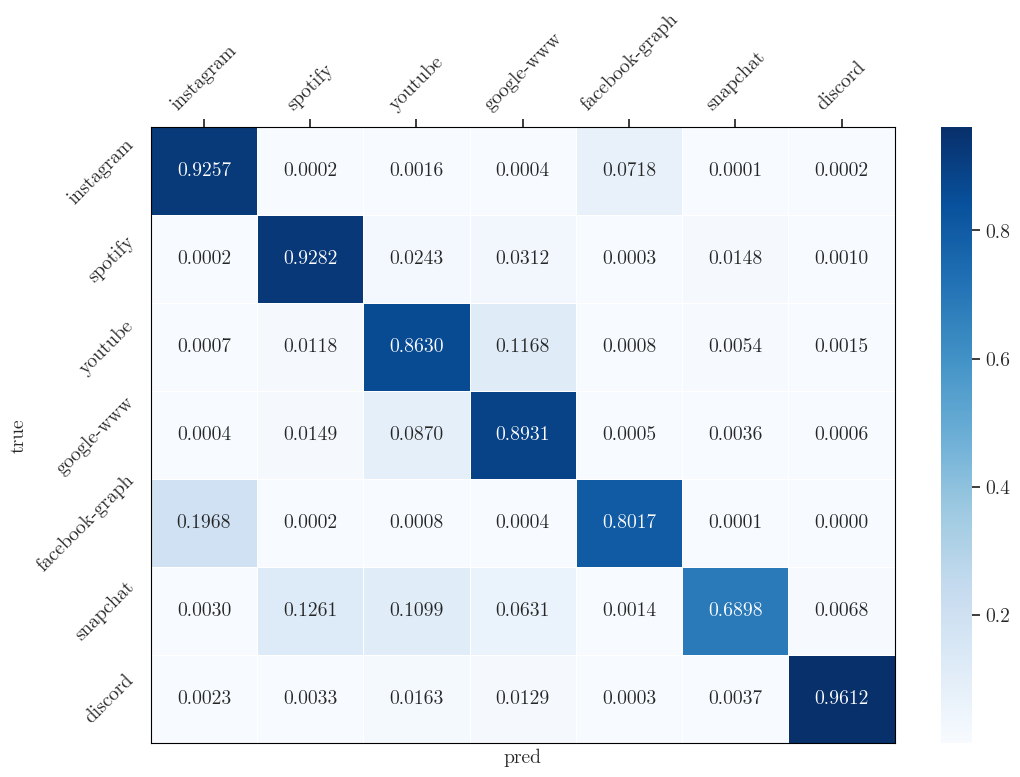

In [ ]:
FSIZE = 14

# Set the font family and size
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 14

cmap = sns.color_palette("Blues", as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 8))

heatmap = sns.heatmap(test_metric_cm
                    , annot=True
                    , fmt=".4f"
                    , linewidths=.5
                    , ax=ax
                    , cmap=cmap
                    , cbar=True
                    , rasterized=False
                    )

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=FSIZE)

for spine in ax.spines.values():
    spine.set(visible=True, lw=.8, edgecolor="black")

# Set up axes
ax.set_xticklabels(c.classes, rotation=45, ha='center', fontsize=FSIZE)  # Rotate the x-axis tick labels by 45 degrees
ax.set_yticklabels(c.classes, rotation=45, ha='right', fontsize=FSIZE)  # Rotate the y-axis tick labels by 45 degrees
ax.set_xlabel('pred', fontsize=FSIZE)
ax.set_ylabel('true', fontsize=FSIZE)

# Move the x-axis tick labels to the top
ax.xaxis.set_tick_params(labeltop=True, labelbottom=False)

# Move the x-axis ticks to the top
ax.tick_params(axis='x', which='both', top=True, bottom=False)
# ax.tick_params(axis='x', which='both', top=False, bottom=False)
# ax.yaxis.set_tick_params(length=0)

# Show the plot
plt.savefig(path(c.path_results, "scenarios", "CL", scenario_name, "fig_confusion_matrix.png"), dpi=300, bbox_inches='tight')